In [3]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves

ModuleNotFoundError: No module named 'pandas'

In [ ]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [ ]:
fred_cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS', 'GS10', 'GS3M', 'FII10'], start=report_start, end=report_end)
real_gdp = web.get_data_fred('GDPC1', start=report_start, end= report_end)

In [ ]:
#Since CPIAUCSL is indexed to 1982-1984=100, we need to convert it to annual percentage changes
fred_cpi_ffr.update(fred_cpi_ffr.CPIAUCSL.pct_change(12, fill_method='bfill')*100)

# For real GDP I translate the growth over on quarter into annual rate to be consistent with
# how the BEA does it.
real_gdp_quarterly = ((real_gdp/real_gdp.shift()).pow(4)-1)

#If instead you want to calculate GDP growth over the whole year, the correct way to do that is
real_gdp = real_gdp.rolling(4).mean().pct_change(4, fill_method='bfill').loc['1970':]

fred_cpi_ffr = fred_cpi_ffr.loc['1970':]
fred_cpi_ffr.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI', 'FEDFUNDS': 'Federal Funds Effective Rate',
             'GS10': '10y Treasury Yield', 'GS3M':'3m Treasury Yield',
             'FII10':'10y TIPS Yields'},
    inplace=True
)
real_gdp.rename(columns={'GDPC1': 'Real GDP'}, inplace=True)
real_gdp['Real GDP over quarter at annual rate'] = real_gdp_quarterly
fred_cpi_ffr /= 100.
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
fred_cpi_ffr.loc['2020':]


C:\Users\drebi\AppData\Local\Temp\ipykernel_45784\3188612773.py:2: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in Series.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fred_cpi_ffr.update(fred_cpi_ffr.CPIAUCSL.pct_change(12, fill_method='bfill')*100)
C:\Users\drebi\AppData\Local\Temp\ipykernel_45784\3188612773.py:9: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  real_gdp = real_gdp.rolling(4).mean().pct_change(4, fill_method='bfill').loc['1970':]


,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield,3m Treasury Yield,10y TIPS Yields
DATE,,,,,
2020-01-01,2.5123%,1.5500%,1.7600%,1.5500%,0.0400%
2020-02-01,2.3397%,1.5800%,1.5000%,1.5400%,-0.1100%
2020-03-01,1.5231%,0.6500%,0.8700%,0.3000%,-0.1200%
2020-04-01,0.3499%,0.0500%,0.6600%,0.1400%,-0.4500%
2020-05-01,0.2162%,0.0500%,0.6700%,0.1300%,-0.4400%
...,...,...,...,...,...
2023-11-01,3.1395%,5.3300%,4.5000%,5.5200%,2.2000%
2023-12-01,3.3232%,5.3300%,4.0200%,5.4400%,1.8400%
2024-01-01,3.1060%,5.3300%,4.0600%,5.4500%,1.7900%


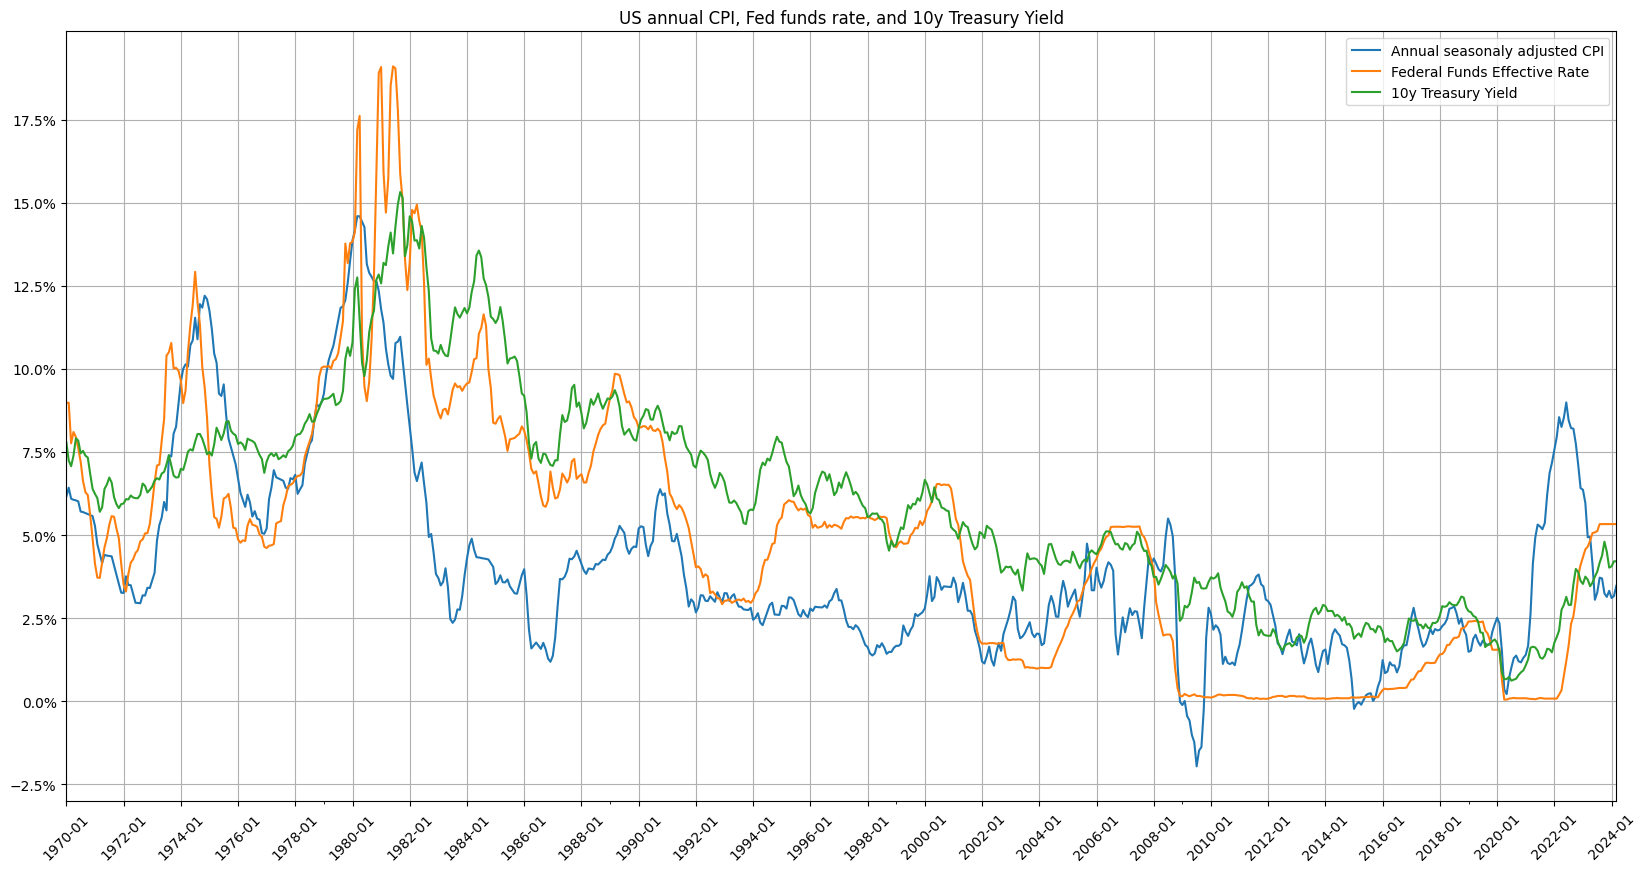

In [ ]:
ax = fred_cpi_ffr.iloc[:,:-2].plot(figsize=(20,10), grid=True, title='US annual CPI, Fed funds rate, and 10y Treasury Yield',
                       xticks=fred_cpi_ffr.index[::24], xlabel='', rot=45, yticks=np.arange(-.025, .2, 0.025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_cpi_ffr.index[::24])))

In [ ]:
from_date = date(2020, 1, 1)
cpi = web.get_data_fred('CPIAUCSL', start= report_start, end=report_end)
cpi_monthly = cpi.pct_change(fill_method='bfill').loc[from_date:, 'CPIAUCSL'].rename('CPI Change Over Prev Month')
cpi_annual = ((cpi/cpi.shift(1)).pow(12)-1).loc[from_date:, 'CPIAUCSL'].rename('CPI Change over Prev Month at Annual Rate')
cpi_quarterly = ((cpi/cpi.shift(3)).pow(4)-1).loc[from_date:, 'CPIAUCSL'].rename('CPI Change over Prev 3 Months at Annual Rate')

C:\Users\drebi\AppData\Local\Temp\ipykernel_45784\1540185563.py:3: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cpi_monthly = cpi.pct_change(fill_method='bfill').loc[from_date:, 'CPIAUCSL'].rename('CPI Change Over Prev Month')


In [ ]:
cpi_df = pd.concat([fred_cpi_ffr.loc[from_date:].iloc[:,0], cpi_quarterly, cpi_annual], axis=1)
cpi_df

,Annual seasonaly adjusted CPI,CPI Change over Prev 3 Months at Annual Rate,CPI Change over Prev Month at Annual Rate
DATE,,,
2020-01-01,2.5123%,2.7516%,1.2881%
2020-02-01,2.3397%,2.1373%,1.5873%
2020-03-01,1.5231%,-0.7403%,-4.9569%
2020-04-01,0.3499%,-4.2263%,-9.0132%
2020-05-01,0.2162%,-5.1407%,-1.2947%
...,...,...,...
2023-11-01,3.1395%,2.4215%,1.9408%
2023-12-01,3.3232%,1.9062%,2.8333%
2024-01-01,3.1060%,2.8312%,3.7274%


In [ ]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'

In [ ]:
cpi_df = cpi_df.loc['2020':, cpi_df.columns[0:2]]
cpi_df.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=cpi_df.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)


,Annual seasonaly adjusted CPI,CPI Change over Prev 3 Months at Annual Rate
DATE,,
2022-10,7.75%,3.97%
2022-11,7.12%,4.74%
2022-12,6.41%,3.38%
2023-01,6.36%,3.39%
2023-02,5.97%,3.89%
2023-03,4.94%,3.98%
2023-04,4.94%,3.61%
2023-05,4.12%,2.49%
2023-06,3.05%,3.03%


In [ ]:
# real_gdp.loc['2020':]
real_gdp.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=real_gdp.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Real GDP,Real GDP over quarter at annual rate
DATE,,
2019-10,2.47%,2.59%
2020-01,2.31%,-5.34%
2020-04,-0.14%,-28.02%
2020-07,-1.17%,34.84%
2020-10,-2.21%,4.21%
2021-01,-2.12%,5.24%
2021-04,2.54%,6.22%
2021-07,4.12%,3.30%
2021-10,5.80%,6.96%


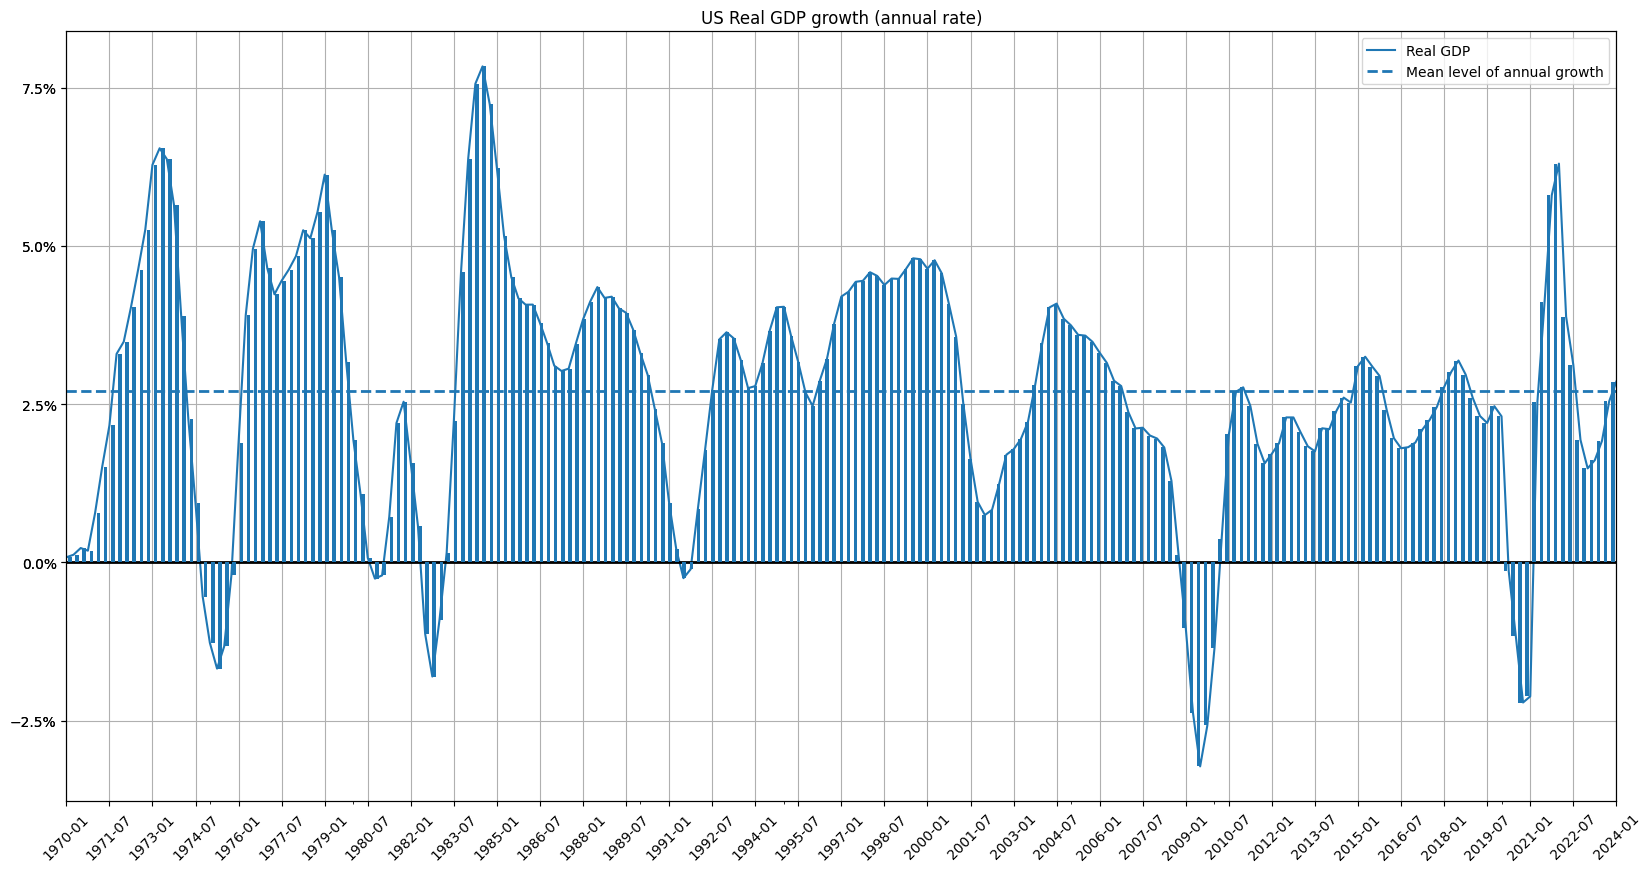

In [23]:
ax = real_gdp.iloc[:,0].plot(figsize=(20,10), grid=True, title='US Real GDP growth (annual rate)',
                             xticks=real_gdp.index[::6], xlabel='', rot=45, yticks=np.arange(-.05, .125, 0.025))

ax.axhline(y=0, lw=2, c='k')
ax.axhline(y=real_gdp.iloc[:,0].mean(), lw=2, ls='--', c='#1f77b4', label='Mean level of annual growth')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2 = ax.twiny()
real_gdp.iloc[:,0].plot.bar(ax=ax2, xlabel='', legend=False)
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_gdp.index[::6])))


In [24]:
print(f'Mean level of annual GDP growth since {real_gdp.index[0]:%Y-%m-%d}: {real_gdp.iloc[:,0].mean():.2%}')

Mean level of annual GDP growth since 1970-01-01: 2.70%


In [25]:
df = pd.concat([real_gdp.iloc[:,0], fred_cpi_ffr.resample('qs').mean()], axis=1)
df.loc['1981':]

C:\Users\drebi\AppData\Local\Temp\ipykernel_45784\3204278823.py:1: FutureWarning: 'qs' is deprecated and will be removed in a future version, please use 'QS' instead.
  df = pd.concat([real_gdp.iloc[:,0], fred_cpi_ffr.resample('qs').mean()], axis=1)


,Real GDP,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield,3m Treasury Yield,10y TIPS Yields
DATE,,,,,,
1981-01-01,-0.2058%,11.2663%,16.5700%,12.9600%,NaN,NaN
1981-04-01,0.7188%,9.8750%,17.7800%,13.7500%,NaN,NaN
1981-07-01,2.2001%,10.8525%,17.5767%,14.8467%,15.6100%,NaN
1981-10-01,2.5377%,9.5877%,13.5867%,14.0867%,12.3000%,NaN
1982-01-01,1.5639%,7.5851%,14.2267%,14.2933%,13.5033%,NaN
...,...,...,...,...,...,...
2023-01-01,1.4847%,5.7542%,4.5167%,3.6467%,4.7800%,1.3533%
2023-04-01,1.6146%,4.0383%,4.9900%,3.5933%,5.2667%,1.3667%
2023-07-01,1.9193%,3.5615%,5.2600%,4.1500%,5.5367%,1.8233%


In [26]:
df = df.loc['1997':, :]

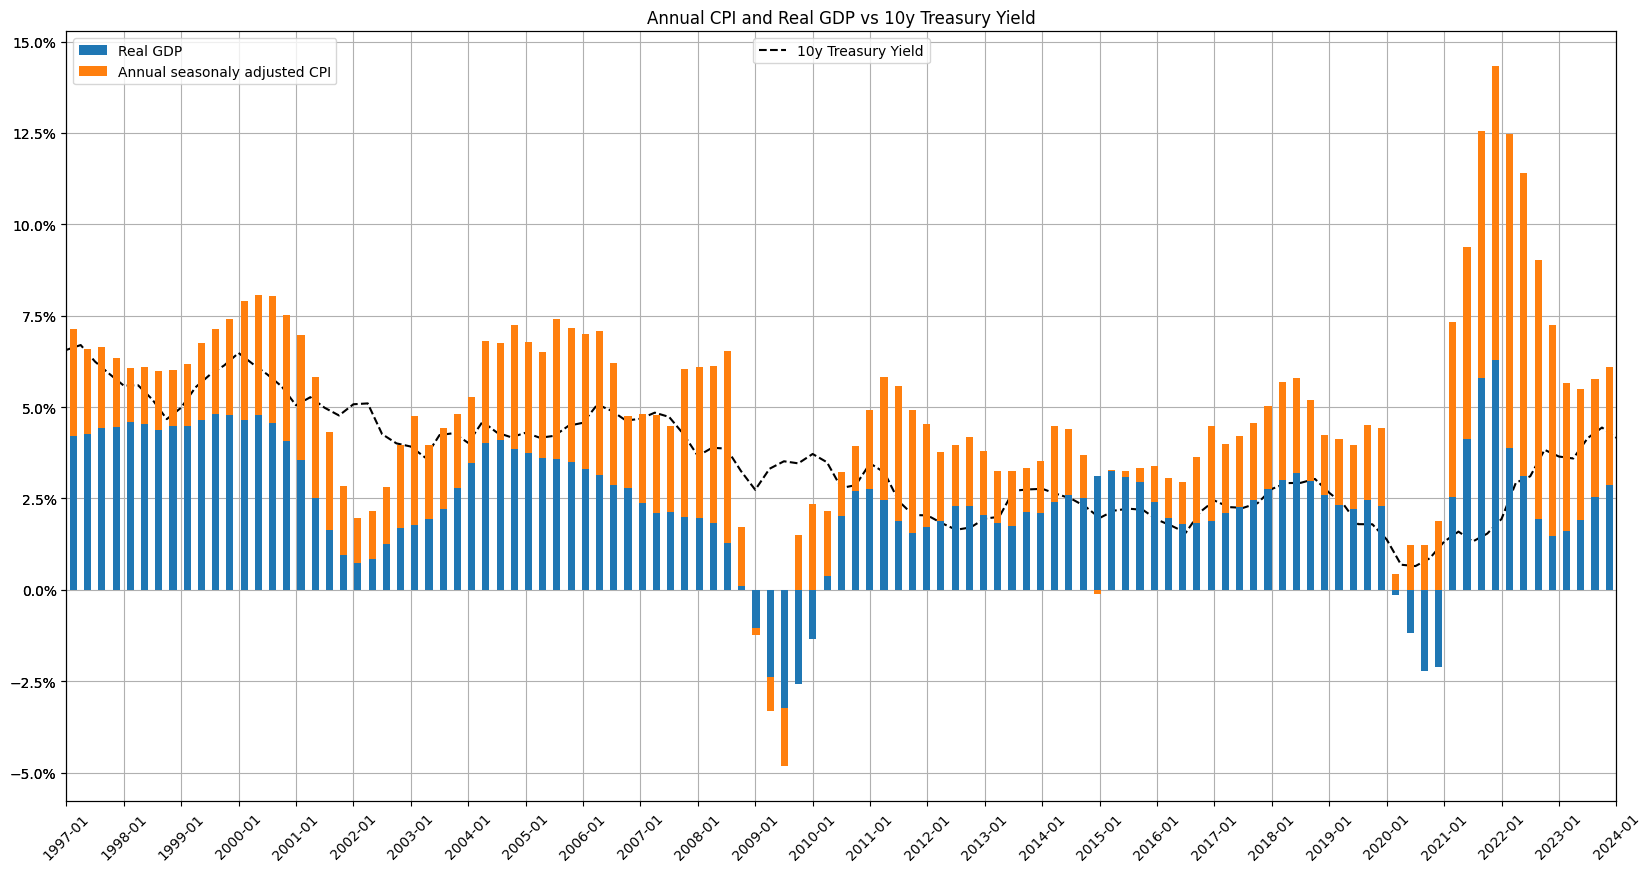

In [27]:
ax = df.iloc[:, -3].plot(figsize=(20,10), grid=True,
                         title='Annual CPI and Real GDP vs 10y Treasury Yield', 
                         xticks=df.index[::4], yticks=np.arange(-.075, .2, 0.025),
                         xlabel='', rot=45, linestyle='--', color='k')
ax2 = ax.twiny()
df.iloc[:,[0,1]].plot.bar(ax=ax2, xlabel='', stacked=True)
#df.iloc[:, -1].plot(ax=ax, grid=True, xticks=df.index[::4], xlabel='', rot=45, linestyle='dotted', color='k')
ax.legend(loc='upper center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::4])))